## Navigation Towards a Goal to Demonstrate a Minimal Mechanism of Cumulative Culture

*William Mills* - 
*University of Bristol Undergraduate Dissertation* - 
*Pre-registered at https://osf.io/3b7dg*

### Import all Libraries

In [5]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import plotly.subplots as sp
import os
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm import tqdm
import statsmodels.api as sm
import statsmodels.stats as sms
from plotly.subplots import make_subplots
import plotly.offline as pyo
import matplotlib
from matplotlib import pyplot
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.stats.power as smp
from scipy.stats import levene, ttest_ind
from scipy import stats
from scipy.stats import mannwhitneyu


### Data Analysis Class

In [13]:

class DataAnalysisCCE:
    def __init__(self, root, output) -> None:
        self.root = root
        self.output_folder = output
        self.total_sample_size = 0
        self.outliers = None
        self.test_data = None
        self._data = None
        self._visual_data = None
        self._descriptive_data = None
        self._model_fit_data = None
        self.remove_outliers = True
        self.remove_incomplete = True
        self.all_participant_files = None
        self.optimal_distance = 424.539
        self.run_efficiency_df = None
        self.all_run_files = []
        self.time_data = None

    # getters and setters for data properties
    #------------------------------------------------------------

    @property
    def descriptive_data(self):
        return self._descriptive_data
    
    @descriptive_data.setter
    def descriptive_data(self, data):
        self._descriptive_data = data

    @property
    def model_data(self):
        return self._model_fit_data
    
    @model_data.setter
    def model_data(self, data):
        self._model_fit_data = data

    @property
    def visual_data(self):
        return self._visual_data
    
    @visual_data.setter
    def visual_data(self, data):
        self._visual_data = data

    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, data):
        self._data = data

    @property
    def total_sample_size(self):
        return self._total_sample_size
    
    @total_sample_size.setter
    def total_sample_size(self, size):
        self._total_sample_size = size

    def save_data(self):
        print('Saving data...')
        self._data.to_csv(f'{self.output_folder}cleaned_data_.csv')
        return self._data


    # load data from csv files and clean it
    #------------------------------------------------------------
    def load_data(self):
        print('Loading data...')
        paths = []
        participants = []
        for dirpath, dirnames, filenames in os.walk(self.root):
            for file in filenames:
                if 'path' in file.lower():
                    paths.append(pd.read_csv(os.path.join(dirpath, file)))
                elif 'participant' in file.lower():
                    participants.append(pd.read_csv(os.path.join(dirpath, file)))
                elif 'run' in file.lower():
                    self.all_run_files.append(pd.read_csv(os.path.join(dirpath, file)))
        
        self.all_participant_files = participants
        self._data = self.clean_data(participants, paths)
        self.all_run_files = pd.concat(self.all_run_files)
        self.all_run_files = self.all_run_files.drop_duplicates()
        return self._data
    
    def output_sample_size(self, size, message="", df=None):
        print('\n' + '-' * 50)
        print(f'{message} | Total Sample Size: {size}')
        if df is not None:
            print(f'Sample Size per Condition: {df["condition_part_1"].value_counts()}')
        print('-' * 50 + '\n')

    def wrangle(self, ready_made = False):
        if not ready_made:
            self.data = self.load_data()
            self.total_distance_per_nr()
            self.descriptive_data = self.format_for_descriptives()
            #self.model_data = self.format_for_model()
            self.run_efficiency_df = self.format_for_run_efficiency()
            print('Completed wrangling.')
        else:
            try:
                self.data = pd.read_csv(f'{self.output_folder}cleaned_data.csv')
                print('Sample Size: ', len(self.data['participant_id'].unique()))

                self.descriptive_data = pd.read_csv(f'{self.output_folder}descriptive_data_raw.csv')

                self.model_data = [pd.read_csv(f'{self.output_folder}model_data_x.csv'), pd.read_csv(f'{self.output_folder}model_data_y.csv')]

                self.run_efficiency_df = pd.read_csv(f'{self.output_folder}route_efficiency_analysis.csv')
            except FileNotFoundError:
                print('No previous csv data computed./nComputing from raw files...')
                self.wrangle(ready_made=False)

    def clean_data(self, participants, paths):
        print('Cleaning data...')
        # get all participants within age range, remove test data, and remove outliers
        participant_info = pd.concat(participants)
        participant_info = participant_info.drop_duplicates()
        print('Initial Sample: ', len(participant_info['participant_id'].unique()))
        print(f'Number of test runs removed: {len(participant_info[(participant_info["age_years"] < 18) | (participant_info["age_years"] > 80)]["participant_id"].tolist())}')
        participant_set = participant_info[(participant_info['age_years'] > 18) & (participant_info['age_years'] < 80)]['participant_id'].to_list()
        
        # get all paths and remove test data
        participant_paths = pd.concat(paths)
        participant_paths.columns = participant_paths.columns.str.lower()
        participant_paths = participant_paths[participant_paths['participant_id'].isin(participant_set)]
        participant_info = participant_info[participant_info['participant_id'].isin(participant_set)]
        
        temp = pd.merge(participant_paths[['participant_id']], participant_info[['participant_id', 'condition_part_1']], on='participant_id', how='left')
        temp = temp.drop_duplicates()
        temp = temp.replace({'condition_part_1': {2: 'diffusion', 1: 'paired', 0: 'single'}})
        print('Sample Size: ', len(temp['participant_id'].unique()))


        if self.remove_outliers:
            # remove outliers and corrupt data
            participant_paths = self.find_path_count_outliers(participant_paths)
            print(len(participant_paths['is_outlier'].unique()), 'outliers found.')
            participant_paths = participant_paths[participant_paths['is_outlier'] == False]

        # remove paths with missing data and duplicates
        participant_paths = participant_paths.dropna(subset=['x', 'y', 'z'])
        participant_paths = participant_paths.drop_duplicates(subset=['participant_id', 'run_id', 'x', 'y', 'z'])

        # add in condition informaton
        participant_paths = pd.merge(participant_paths, participant_info[['participant_id', 'condition_part_1']], on='participant_id', how='left')
        participant_paths = participant_paths.drop_duplicates()

        # adapt nr to be relative to gens per participant
        #df_runs = participant_paths.sort_values(['participant_id', 'run_id'])
        participant_paths['t'] = pd.to_datetime(participant_paths['t'])
        df_runs = participant_paths.sort_values(['t'], ascending=True)
        df_runs = df_runs[df_runs['session_id'] != 'default']
        df_runs = df_runs[df_runs['run_id'] != '0']
        df_sessions = df_runs[['participant_id', 'session_id']].drop_duplicates()
        df_runs = df_runs[['participant_id', 'run_id', 'nr']].drop_duplicates().reset_index(drop=True)
        
        # Create a mapping of participant_id to their index in the session
        participant_index = df_sessions.groupby('session_id').cumcount() + 1
        df_sessions['participant_index'] = participant_index

        # Merge df_runs with df_sessions to add the participant_index column to df_runs
        df_runs = pd.merge(df_runs, df_sessions[['participant_id', 'participant_index']], on='participant_id')

        # Multiply _nr by the participant_index
        df_runs['_nr'] = (df_runs.groupby('participant_id').cumcount() + 1) * df_runs['participant_index']
        participant_paths = participant_paths.sort_values(['participant_id', 'run_id', 'nr'])
        participant_paths = pd.merge(participant_paths, df_runs, on=['participant_id', 'run_id', 'nr'], how='left')

        participant_paths = participant_paths.rename(columns={'session_id_x': 'session_id'})

        # remove if number of recorded paths < 50 (participant dropped out)
        participant_paths = participant_paths.groupby('participant_id').filter(lambda x: len(x) >= 50)
        participant_paths = participant_paths.sort_values(['condition_part_1', '_nr']).reset_index(drop=True)

        # remove run if not complete
        participant_paths = self.remove_if_not_complete_nr(participant_paths)
        #participant_paths = participant_paths.dropna(subset=['is_in_range_x', 'is_in_range_z'])
        #participant_paths = participant_paths[participant_paths['is_in_range_x'] & participant_paths['is_in_range_z']]
        print('Sample Size: ', str(len(temp['participant_id'].unique())) + ' after removing dodgy data.')
        participant_paths.to_csv(f'{self.output_folder}cleaned_data.csv')


        em = pd.DataFrame()
        f = participant_paths[participant_paths['condition_part_1'] == 0]

        # descriptives for path count
        path_counts = []
        for nr in f['_nr'].unique():
            tmp = f[f['_nr'] == nr]['x']
            path_counts.append(len(tmp))

        em['path_count'] = path_counts
        em['path_count'] = em['path_count'].astype(int)
        em['path_count'] = em['path_count'] // 12
        print('Path descriptives')
        print(em['path_count'].describe())



        return participant_paths

    def format_for_descriptives(self):
        data = self.data
        print('Formatting data for descriptives...')
        # reduce to current selection
        all_participant_files = self.all_participant_files
        all_participant_files = pd.concat(all_participant_files)
        all_participant_files = all_participant_files.drop_duplicates()
        all_participant_files = all_participant_files[all_participant_files['participant_id'].isin(data['participant_id'].unique())]
        all_participant_files = all_participant_files.drop_duplicates()
        
        all_participant_files.to_csv(f'{self.output_folder}descriptive_data_raw.csv')
        all_participant_files.describe().to_csv(f'{self.output_folder}descriptive_data.csv')
        return all_participant_files

    def format_for_run_efficiency(self, df:pd.DataFrame=None):
        # the distance to compare with
        optimal_distance = self.optimal_distance
        if df is None:
            df = self.data
        all_dat = self.data.copy()

        df_end = {'_nr':[], 'participant_id':[], 'total_distance':[], 'route_efficiency':[], 'condition_part_1':[]}
        broken_numbers = []
        for participant in df['participant_id'].unique():
            for nr in df[df['participant_id'] == participant]['_nr'].unique():
                tmp = df[(df['participant_id'] == participant) & (df['_nr'] == nr)].copy()
                # add to df_end
                dist, eff = self.get_cumulative_distance(tmp)
                if not np.isinf(eff) and eff != 0 and not np.isnan(eff) and not np.isnan(dist) and dist != 0:
                    if eff > 1 and dist >= optimal_distance:
                        df_end['_nr'].append(nr)
                        df_end['participant_id'].append(participant)
                        df_end['total_distance'].append(dist)
                        df_end['route_efficiency'].append(424.539 / dist)
                        df_end['condition_part_1'].append(all_dat[all_dat['participant_id'] == participant]['condition_part_1'].values[0])

                    elif eff <= 1:
                        df_end['_nr'].append(nr)
                        df_end['participant_id'].append(participant)
                        df_end['total_distance'].append(dist)
                        df_end['route_efficiency'].append(eff)
                        df_end['condition_part_1'].append(all_dat[all_dat['participant_id'] == participant]['condition_part_1'].values[0])
                    else:
                        broken_numbers.append(participant)

        df = pd.DataFrame(df_end)

        # remove buggy runs
        df.loc[df['condition_part_1'] == 1, '_nr'] = df.loc[(df['_nr'] <= 12) & (df['condition_part_1'] == 1), '_nr']
        df.loc[df['condition_part_1'] == 2, '_nr'] = df.loc[(df['_nr'] <= 18) & (df['condition_part_1'] == 2), '_nr']
        df.dropna()
        df.drop_duplicates()
        df['route_efficiency'] = df['route_efficiency'].astype(float)
        df['total_distance'] = df['total_distance'].astype(float)
        df.to_csv(f'{self.output_folder}route_efficiency_analysis.csv')
        return df

    def total_distance_per_nr(self, df=None)->pd.DataFrame:
        print('Calculating total distance per run per participant...')
        if df is None:
            df = self.data
        df = pd.merge(df, self.data[['participant_id', 'run_id', 'nr']], on=['participant_id', 'run_id', 'nr'], how='left')
        nr_distances = {'participant_id':[], 'nr':[], 'total_distance':[], 'route_efficiency':[]}
        for participant in df['participant_id'].unique():
            for nr in df[df['participant_id'] == participant]['nr'].unique():
                tmp = df[(df['participant_id'] == participant) & (df['nr'] == nr)].copy()
                dist, eff = self.get_cumulative_distance(tmp)
                nr_distances['total_distance'].append(dist)
                nr_distances['route_efficiency'].append(eff)
                nr_distances['participant_id'].append(participant)
                nr_distances['nr'].append(nr)

        nr_distances_df = pd.DataFrame(nr_distances)
        #nr_distances = nr_distances_df[['participant_id', 'nr', 'total_distance', 'efficiency']].drop_duplicates()
        nr_distances_df.to_csv(f'{self.output_folder}total_distance.csv')
        return nr_distances_df
    
    def get_cumulative_distance(self, d:pd.DataFrame):
        optimal_distance = self.optimal_distance
        warnings.filterwarnings("ignore")
        d = d.copy()
        
        d['x_shifted'] = d['x'].shift(-1)
        d['y_shifted'] = d['z'].shift(-1)
        distance = np.sqrt((d['x_shifted'] - d['x'])**2 + (d['y_shifted'] - d['z'])**2).sum()
        
        try:
            efficiency = optimal_distance / distance
        except ZeroDivisionError: 
            efficiency = 0

        return distance, efficiency

    def apply_zero_one(self, group):
        group.iloc[:2] = [0, 1]
        return group

    # format data for model fit analysis
    def format_for_model(self):
        df = self.data.copy()
        print('Formatting data for model fit...')
        paths =  df.sort_values(['condition_part_1', '_nr']).reset_index(drop=True)#.groupby(['participant_id', '_nr', 'condition_part_1'])
        paths['gen'] = paths['_nr'] % 6
        paths['_nr'] = paths['_nr'].transform(lambda x: x % 6)
        paths['_nr'] = paths['_nr'].apply(lambda x: 1 if x == 0 else x + 1)
        paths['gen'] = paths['gen'].apply(lambda x: 1 if x == 0 else x + 1)
        paths['runs_at_time'] = paths.groupby(['participant_id', 'run_id'])['participant_id'].apply(self.apply_zero_one)
        paths = paths[['condition_part_1', 'participant_id', 'runs_at_time', 'gen', 'x', 'z' , '_nr']]
        paths.to_csv(f'{self.output_folder}model_data.csv')

        return paths

    def get_time_data(self):
        print('Getting data into time format...')
        df = self.data.copy()
        df.loc[df['condition_part_1'] == 1, '_nr'] = df.loc[(df['_nr'] <= 12) & (df['condition_part_1'] == 1), '_nr']
        df.loc[df['condition_part_1'] == 2, '_nr'] = df.loc[(df['_nr'] <= 18) & (df['condition_part_1'] == 2), '_nr']
        # get all run data
        run = self.all_run_files.copy()
        if run is None or len(run) == 0:
            try:
                r = []
                for dirpath, dirnames, filenames in os.walk(self.root):
                    for file in filenames:
                        if 'run' in file.lower():
                            r.append(pd.read_csv(os.path.join(dirpath, file)))
                run = pd.concat(r)
            except FileNotFoundError:
                print('No run data found.')
                return
            
        df = df.dropna(subset=['_nr', 'run_id'])
        all_runs = df['run_id'].unique()
        run = run[run['run_id'].isin(all_runs)]
        run.columns = run.columns.str.lower()
        run = run[run['session_id'] != 'default']
        run = run[['start_time', 'run_id']]
        run['start_time'] = pd.to_datetime(run['start_time'])
        
        #df = df.merge(run, on='run_id', how='left')
        # time start, time end, time duration, nr, participant_id, condition_part_1, is_finished

        # get time at goal or when run ends if never completed run
        df['at_goal'] = False  # Initialize at_goal column with False
        df.loc[(df['x'] >= 178) & (df['x'] <= 218) & (df['z'] >= 488) & (df['z'] <= 538), 'at_goal'] = True

        df['finish_time_at_goal'] = df['t'].apply(lambda x: x if x in df[df['at_goal'] == True]['t'].values else None)
        df['finish_time_at_goal'] = pd.to_datetime(df['finish_time_at_goal'])
        df['_start_time'] = df.loc[df.groupby(['run_id', '_nr'])['t'].idxmin()]['t']
        df['_start_time'] = pd.to_datetime(df['_start_time'])
        df['finish_time_out'] = df.loc[df.groupby(['run_id', '_nr'])['t'].idxmax()]['t']
        
        df['finished_bc_at_goal'] = df['finish_time_at_goal'].notnull()    
        df['finished_bc_time_out'] = df['finish_time_out'].notnull()

        df_r_t = df[['participant_id', 'run_id', '_nr', 'condition_part_1', 'finish_time_at_goal', 'finish_time_out', '_start_time']].drop_duplicates()

        df_r_t = df_r_t.drop_duplicates()
        # Fill missing values in 'finish_time' column
        df_r_t['finish_time'] = df_r_t['finish_time_at_goal'].fillna(df_r_t['finish_time_out'])
        df_r_t['finish_time'] = pd.to_datetime(df_r_t['finish_time'])

        df_1 = df_r_t[['participant_id', 'run_id', '_nr', 'condition_part_1', '_start_time']].drop_duplicates().dropna(subset='_start_time')
        df_2 = df_r_t[['participant_id', 'run_id', '_nr', 'condition_part_1', 'finish_time']].drop_duplicates().dropna(subset='finish_time')
        df_r_t = pd.merge(df_1, df_2, on=['participant_id', 'run_id', '_nr', 'condition_part_1'], how='left')

        df_r_t['time_duration'] = (df_r_t['finish_time'] - df_r_t['_start_time']).dt.total_seconds()
        df_r_t.to_csv(f'{self.output_folder}time_data.csv')
        df_r_t = df_r_t.dropna(subset=['time_duration'])
        df_r_t['total_runs'] = df_r_t['condition_part_1'].map({0: 12, 1: 12, 2: 24})
        df_r_t['total_runs'] = df_r_t['total_runs'].astype(int)
        df_r_t.loc[df_r_t['condition_part_1'] == 1, '_nr'] = df_r_t.loc[(df_r_t['_nr'] <= 12) & (df_r_t['condition_part_1'] == 1), '_nr']
        df_r_t.loc[df_r_t['condition_part_1'] == 2, '_nr'] = df_r_t.loc[(df_r_t['_nr'] <= 24) & (df_r_t['condition_part_1'] == 2), '_nr']
        
        return df_r_t

    # remove outliers and corrupt data
    #------------------------------------------------------------

    # remove upper and lower outliers from route efficiency
    def remove_route_efficiency_outliers(self, aggregated_df):
        Q1 = aggregated_df['route_efficiency'].quantile(0.25)
        Q3 = aggregated_df['route_efficiency'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        aggregated_df = aggregated_df[(aggregated_df['route_efficiency'] >= lower_bound) & (aggregated_df['route_efficiency'] <= upper_bound)]
        return aggregated_df
    
    def remove_if_not_complete_gen(self, df):
        print('Identifying and removing incomplete generations...')
        if 'participant_id' in df and 'run_id' in df:
            # Check if 'nr' length per 'gen' is 6
            df['nr_length_per_gen'] = df.groupby('run_id')['nr'].transform(len)
            df['did_participant_drop_out'] = df['nr_length_per_gen'] < 5
        else:
            print("Error: 'participant_id' or 'run_id' not found in df")

        return df

    def remove_if_not_complete_nr(self, df):
        print('Identifying and removing incomplete runs...')
        for participant_id, group_df in df.groupby('participant_id'):
            for run_id, run_group in group_df.groupby('run_id'):
                for nr, nr_group in run_group.groupby('_nr'):
                    temp = nr_group
                    if ((temp['x'] >= 178) & (temp['x'] <= 218) & (temp['z'] >= 488) & (temp['z'] <= 528)).any():
                        df.loc[(df['_nr'] == nr) & (df['participant_id'] == participant_id) & (df['run_id'] == run_id), 'is_in_range'] = True
                    else:
                        df.loc[(df['_nr'] == nr) & (df['participant_id'] == participant_id) & (df['run_id'] == run_id), 'is_in_range'] = False
        return df



    # find outliers based on path count (if participants did nothig and dropped out, or dropped out after a few paths)
    def find_path_count_outliers(self, df:pd.DataFrame)->pd.DataFrame:
        print('Identifying outliers in path data...')
        path_count = []
        participant_ids = pd.unique(df['participant_id'])
        for participant_id in participant_ids:
            count = (df['participant_id'] == participant_id).sum()
            path_count.append(count)

        _df = pd.DataFrame({'Participant_ID': participant_ids, 'Path_Count': path_count})
        df_mean = _df['Path_Count'].mean()
        df_std = _df['Path_Count'].std()
        outliers = _df[(_df['Path_Count'] < 200) | (_df['Path_Count'] > df_mean + (1.5 * df_std))]
        df['is_outlier'] = df['participant_id'].apply(lambda x: x in outliers['Participant_ID'].values)
        x = df['is_outlier'].drop_duplicates()
        print(str(len(x.unique())), 'outliers found.')
        return df
    
    def find_test_data(self, df:pd.DataFrame)->pd.DataFrame:
        print('Identifying test data...')
        df['test_data'] = df[df['age_years'] == 255 | df['age_years'] < 18 | df['age_years'] > 80]
        return df
    

    # visualize data
    #------------------------------------------------------------

    def visualize(self):
        if self.data is None:
            print('No data to visualize. Please wrangle data first.')
            return
        self.plot_run_efficiency()
        self.plot_proportion_in_range()
        self.plot_runs()
        self.plot_participant_time()
        self.plot_time_duration()


    def plot_run_efficiency(self, df=None):
        if df is None:
            df = self.run_efficiency_df

        df = df.groupby(['condition_part_1', '_nr'])[['route_efficiency', 'total_distance']].mean().reset_index()
        df.loc[df['condition_part_1'] == 1, '_nr'] = df.loc[(df['_nr'] <= 12) & (df['condition_part_1'] == 1), '_nr']
        df.loc[df['condition_part_1'] == 2, '_nr'] = df.loc[(df['_nr'] <= 18) & (df['condition_part_1'] == 2), '_nr']

        y_min = 0
        y_max = 0.5 

        color_scale = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        conditions = ['Single', 'Paired', 'Diffusion']
        df['_nr'] = df['_nr'].astype(int)
        fig = go.Figure()

        for condition, group_df in df.groupby('condition_part_1'):
            color = 'black'
            if condition == 0:
                color = 'black'
            elif condition == 1:
                color = 'blue'
            elif condition == 2:
                color = 'red'
            
            fig.add_trace(go.Scatter(
                x=group_df['_nr'],
                y=group_df['route_efficiency'],
                mode='lines+markers',
                name=f'{conditions[condition]}',
                line=dict(color=color))
            )

        # Update layout
        fig.update_layout(
            title="Route Efficiency by Generation",
            xaxis_title="Run Number",
            yaxis_title="Route Efficiency",
            font=dict(family="Times New Roman", size=18, color='black'),
            plot_bgcolor='rgb(240, 245, 245)',
            width=1000
        )

        fig.update_yaxes(range=[y_min, y_max])

        fig.show()

    def fill_is_in_range(self, row):
        matching_rows = self.data.loc[(self.data['condition_part_1'] == row['condition_part_1']) & (self.data['_nr'] == row['_nr']) & (self.data['participant_id'] == row['participant_id']), 'is_in_range'].values
        return matching_rows[0] if len(matching_rows) > 0 else False
    
    def plot_run_efficiency_max_per_gen(self, df=None, include_incomplete=True):
        if df is None:
            df = self.run_efficiency_df

        df = df[df['route_efficiency'] < 1]
        df = df[df[['condition_part_1', '_nr', 'participant_id']].isin(self.data[['condition_part_1', '_nr', 'participant_id']]).all(axis=1)]

        # If not include_incomplete, fill NaN values of 'is_in_range' with False
        if not include_incomplete:
            df['is_in_range'] = df.apply(self.fill_is_in_range, axis=1)

        df = df.groupby(['condition_part_1', '_nr'])[['route_efficiency', 'total_distance']].max().reset_index()
        df.loc[df['condition_part_1'] == 1, '_nr'] = df.loc[(df['_nr'] <= 12) & (df['condition_part_1'] == 1), '_nr']
        df.loc[df['condition_part_1'] == 2, '_nr'] = df.loc[(df['_nr'] <= 18) & (df['condition_part_1'] == 2), '_nr']
        
        color_scale = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        conditions = ['Single', 'Paired', 'Diffusion']

        for condition, group_df in df.groupby('condition_part_1'):
            fig = go.Figure()
            fig.add_trace(go.Scatter(
                x=group_df['_nr'],
                y=group_df['route_efficiency'],
                mode='lines+markers',
                name=f'{conditions[condition]}',
                line=dict(color='black'))
            )

            # Update layout
            fig.update_layout(
                title=f"Max Route Efficiency Per Run - {conditions[condition]}\nInclude Incomplete: {include_incomplete}",
                xaxis_title="Run Number",
                yaxis_title="Route Efficiency",
                font=dict(family="Times New Roman", size=18, color='black')
            )

            fig.show()

    def plot_run_efficiency_seperate(self, df=None):
        if df is None:
            df = self.run_efficiency_df

        df = df.groupby(['condition_part_1', '_nr'])[['route_efficiency', 'total_distance']].mean().reset_index()
        df.loc[df['condition_part_1'] == 1, '_nr'] = df.loc[(df['_nr'] <= 12) & (df['condition_part_1'] == 1), '_nr']
        df.loc[df['condition_part_1'] == 2, '_nr'] = df.loc[(df['_nr'] <= 18) & (df['condition_part_1'] == 2), '_nr']

        y_min = 0
        y_max = 0.5 

        color_scale = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        conditions = ['Single', 'Paired', 'Diffusion']

        for condition, group_df in df.groupby('condition_part_1'):
            fig = go.Figure()
            fig.add_trace(go.Scatter(
                x=group_df['_nr'],
                y=group_df['route_efficiency'],
                mode='lines+markers',
                name=f'{condition}',
                line=dict(color='black'))
            )

            # Update layout
            fig.update_layout(
                title=f"Route Efficiency by Generation - {conditions[condition]}",
                xaxis_title="Run Number",
                yaxis_title="Route Efficiency",
                font=dict(family="Times New Roman", size=18, color='black')
            )

            y_min = 0
            y_max = 0.45
            fig.update_yaxes(range=[y_min, y_max])

            fig.show()

    def plot_r(self):
        df = self.data.copy()
        df = df[df['condition_part_1'] == 2]
        # pick random session
        session = df['session_id'].sample(1).values[0]
        df = df[df['session_id'] == session]
        df['t']= pd.to_datetime(df['t'])
        lower_threshold = np.percentile(df['x'], 1)
        upper_threshold = np.percentile(df['x'], 99)

        # Filter the dataframe to remove outliers
        filtered_annie = df[(df['x'] > lower_threshold) & (df['x'] < upper_threshold)]
        filtered_annie = filtered_annie[filtered_annie['z'] > 0]
        # Sort the DataFrame by 'x' to ensure the line connects the points in order
        filtered_annie = filtered_annie.sort_values(by='t')

        plt.rcParams['font.family'] = 'Times New Roman'

        # Plot x and z positions with color defined by _nr and connect sequential points with lines
        plt.figure(figsize=(5, 9))  # Adjust figure size here
        xc = 0
        for nr, group in filtered_annie.groupby('run_id'):
            group = group.sort_values(by='t')
            group = group[group['_nr'] == 6]
            if xc != 0:
                plt.plot(group['x'], group['z'], label=f'Generation {xc}')
                plt.plot(group['x'], group['z'], linestyle='-', linewidth=1, color='gray', alpha=0.5)  # Connect sequential points
            xc += 1
        plt.title('X and Z positions')
        plt.xlabel('x')
        plt.ylabel('z')
        plt.legend()
        plt.show()

    def plot_runs_long(self, df=None):
        if df is None:
            if self.data is None:
                try:
                    self.data = pd.read_csv(f'{self.output_folder}cleaned_data.csv')
                except FileNotFoundError:
                    print('No data to visualize. Please wrangle data first.')
                    return
            else:
                df_paths = self.data
        else:
            df_paths = df

        df_paths.loc[df_paths['condition_part_1'] == 1, '_nr'] = df_paths.loc[(df_paths['_nr'] <= 12) & (df_paths['condition_part_1'] == 1), '_nr']
        df_paths.loc[df_paths['condition_part_1'] == 2, '_nr'] = df_paths.loc[(df_paths['_nr'] <= 18) & (df_paths['condition_part_1'] == 2), '_nr']
        df_paths['participant_id'] = df_paths['participant_id'].astype('category')
        df_paths['participant_id'] = df_paths['participant_id'].cat.codes
        df_paths = df_paths.dropna(subset=['_nr', 'run_id'])
        _nrs = df_paths['_nr'].unique()
        nrows = min(6, len(_nrs))
        ncols = int(np.ceil(len(_nrs) / 6))
        fig = sp.make_subplots(rows=nrows, cols=ncols, subplot_titles=[f'nr: {nr}' for nr in _nrs])
        for cons in df_paths['condition_part_1'].unique():
            df_paths_cons = df_paths[df_paths['condition_part_1'] == cons]
            for i, _nr in enumerate(_nrs, start=1):
                df_paths_cons_nr = df_paths_cons[df_paths_cons['_nr'] == _nr]
                heatmap = px.density_heatmap(df_paths_cons_nr, x='x', y='z', marginal_x='histogram', marginal_y='histogram', nbinsx=50, nbinsy=50)
                col = (i - 1) // 6 + 1
                row = (i - 1) % 6 + 1
                fig.add_trace(heatmap.data[0], row=row, col=col)

            fig.update_layout(height=400*nrows, width=400*ncols, title_text="Density Heatmap - Condition: " + str(cons))
            pyo.plot(fig, filename=f'heatmap_{cons}.html')
            fig.show()


    def plot_runs(self, df=None):
        if df is None:
            if self.data is None:
                try:
                    self.data = pd.read_csv(f'{self.output_folder}cleaned_data.csv')
                except FileNotFoundError:
                    print('No data to visualize. Please wrangle data first.')
                    return
            else:
                df_paths = self.data
        else:
            df_paths = df
            
        df_paths.loc[df_paths['condition_part_1'] == 1, '_nr'] = df_paths.loc[(df_paths['_nr'] <= 12) & (df_paths['condition_part_1'] == 1), '_nr']
        df_paths.loc[df_paths['condition_part_1'] == 2, '_nr'] = df_paths.loc[(df_paths['_nr'] <= 18) & (df_paths['condition_part_1'] == 2), '_nr']
        df_paths['participant_id'] = df_paths['participant_id'].astype('category')
        df_paths['participant_id'] = df_paths['participant_id'].cat.codes
        df_paths = df_paths.dropna(subset=['_nr', 'run_id'])
        df_paths['_nr'] = df_paths['_nr'].astype(int)  # Convert 'run_id' to integer
        _nrs = df_paths['_nr'].unique()[:12]  # Select only the first 12 unique _nr values
        nrows = int(np.ceil(np.sqrt(len(_nrs))))
        ncols = int(np.ceil(len(_nrs) / nrows))
        fig = sp.make_subplots(rows=nrows, cols=ncols, subplot_titles=[f'nr: {nr}' for nr in _nrs], horizontal_spacing=0.05, vertical_spacing=0.05)

        for i, _nr in enumerate(_nrs, start=1):
            df_nr = df_paths[(df_paths['_nr'] == _nr) & (df_paths['_nr'] <= 12)]  # Filter dataframe to include only the first 12 runs
            heatmap = px.density_heatmap(df_nr, x='x', y='z', marginal_x='histogram', marginal_y='histogram', nbinsx=50, nbinsy=50)
            heatmap.update_traces(textfont=dict(family="Times New Roman", size = 18))
            fig.add_trace(heatmap.data[0], row=(i-1)//ncols+1, col=(i-1)%ncols+1)

        fig.update_layout(height=400*nrows, width=400*ncols, title_text=None, font=dict(family="Times New Roman", size=18), showlegend=False)
        pyo.plot(fig, filename='3d_scatter.html')
        fig.show()




    def plot_participant_time(self, df=None):
        df_r_t = self.get_time_data()
        # plot position per participant
        for condition, group_df in df_r_t.groupby('condition_part_1'):
            plt.figure(figsize=(10, 6))  # Adjust figure size as needed
            for nr, nr_group in group_df.groupby('_nr'):
                plt.plot(nr_group['participant_id'], nr_group['time_duration'], marker='o', label=nr)
            plt.title(f'Time Duration for Condition: {condition}')
            plt.xlabel('Participant ID')
            plt.ylabel('Time Duration (seconds)')
            plt.legend()
            plt.grid(True)
            plt.show()

    def plot_time_duration(self):
        df = self.get_time_data()
        # plot avg duration over conditions
        mean_time_per_condition_nr = df.groupby(['condition_part_1', '_nr'])['time_duration'].mean().reset_index()

        plt.figure(figsize=(10, 6))  # Adjust figure size as needed
        sns.lineplot(data=mean_time_per_condition_nr, x='_nr', y='time_duration', hue='condition_part_1', palette='colorblind')
        plt.title('Average Time Duration for Each Condition Across _nr')
        plt.xlabel('_nr')
        plt.ylabel('Average Time Duration (seconds)')
        plt.grid(True)
        plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

        plt.figure(figsize=(10, 6))  # Adjust figure size as needed
        sns.lineplot(data=mean_time_per_condition_nr, x='_nr', y='time_duration', hue='condition_part_1', palette='colorblind')
        plt.title('Average Time Duration for Each Condition Across _nr')
        plt.xlabel('_nr')
        plt.ylabel('Average Time Duration (seconds)')
        plt.grid(True)
        plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    def plot_proportion_in_range(self):
        df = self.data.copy()

        df['_nr'] = df['_nr'].transform(lambda x: x % 12 if (x != 12 and x != 6) else x)
        df = df.sort_values(['condition_part_1', '_nr'])
        # Group by _nr and condition, calculate the proportion of is_in_range = True
        proportions = df.groupby(['_nr', 'condition_part_1'])['is_in_range'].mean().unstack()
        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Find the global min and max proportions to set the same y scale for all subplots
        global_min = 0
        global_max = proportions.max().max() + 0.05
        proportions = proportions.rename(columns={0: 'Single', 1: 'Paired', 2: 'Diffusion'})
        # Plot the proportions for each condition on the same plot
        proportions.plot(kind='bar', ax=ax, edgecolor='black', linewidth=1)
        ax.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at y=0

        plt.title('Proportion of Runs Finished Per Condition')
        plt.xlabel('Run Number')
        plt.ylabel('Proportion (0 to 1)')
        plt.legend(title='Condition', labels=proportions.columns)

        plt.ylim(global_min, global_max)  # Set the same y scale for all subplots

        plt.tight_layout()
        plt.show()


    # analyse data
    #------------------------------------------------------------

    def analyze(self, truncated=True):
        if self.data is None:
            print('No data to analyze. Please wrangle data first.')
            return
        
        self.descriptives()
        self.lme()

    def descriptives(self):
        print('Descriptives\n' + '-'*50)
        if os.path.exists('descriptive_data.csv'):
            print(pd.read_csv(f'{self.output_folder}descriptive_data.csv'))
        else:
            print('Calculating descriptive statistics...')
            df = self.descriptive_data
            print(df.describe())    

    def lmm_analysis_time(self):
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.style.use('grayscale')  # Set the plot style
        print('Linear Mixed Effects Model of Time Duration\n' + '-'*50)
        df = pd.read_csv(f'{self.output_folder}time_data.csv')
        df_2 = self.data.copy()
        df = df.merge(df_2[['participant_id', 'session_id']].drop_duplicates(), on='participant_id', how='left')
        df = df.sort_values(['participant_id', '_nr'])
        # if you want just first penultimate, and last runs:

        df = df.groupby('participant_id').nth([-5, -2, -1]).reset_index()
        #df['_nr'] = df['_nr'].map({df['_nr'].iloc[0]: 'first', df['_nr'].iloc[1]: 'penultimate', df['_nr'].iloc[2]: 'last'})
        df['avg_time_duration'] = df.groupby('participant_id')['time_duration'].transform('mean')
        df = df.dropna()
        df = df.drop_duplicates()
        #df = df[df['_nr'] == 'last']
        # do lmm analysis
        print('Time Duration Model')
        
        model = smf.mixedlm("avg_time_duration ~ condition_part_1", df, groups=df["session_id"], re_formula="1")
        result = model.fit()
        print(result.summary())
        plt.figure(figsize=(8, 6))
        plt.scatter(df['condition_part_1'], df['avg_time_duration'], label='Data')
        plt.plot(df['condition_part_1'], result.fittedvalues, color='grey', label='MixedLM')
        plt.xlabel('Condition')
        plt.ylabel('Time Duration (Seconds)')
        plt.title('Mixed Linear Model')
        plt.legend()
        plt.show()

        # post hoc analysis
        print('Post Hoc Analysis')
        self.planned_comparisons(df, 'avg_time_duration')


    def kill_outliers(self, df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        return df

    
    def lme(self):
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.style.use('bmh')  # Set the plot style
        df = pd.read_csv(f'{self.output_folder}lme_data.csv')

        # Pre-reg LME
        df_grouped = df.groupby('participant_id').apply(lambda x: x.loc[x['_nr'].isin([x['_nr'].max() - 5, x['_nr'].max(), x['_nr'].max()-1]), 'route_efficiency'].mean())
        df_grouped = df_grouped.reset_index().rename(columns={0: 'avg_route_efficiency'})
        df = df.merge(df_grouped, on='participant_id', how='left')
        df = df.dropna(subset=['avg_route_efficiency'])
        df = df.drop_duplicates(subset=['participant_id'])
        df['session_id'] = df['session_id'].astype(str)
        df['session_id'] = df['session_id'].astype('category')
        df = self.kill_outliers(df, 'avg_route_efficiency')
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='condition_part_1', y='avg_route_efficiency', data=df, color='gray')
        plt.title('Average Route Efficiency Across Conditions')
        plt.xlabel('Condition')
        plt.ylabel('Average Route Efficiency')
        plt.show()

        print('\n\npre-reg with session_id as random effect')
        formula = 'avg_route_efficiency ~ condition_part_1'
        model = sm.MixedLM.from_formula(formula, df, groups=df['session_id'], re_formula='1')
        result = model.fit()
        print(result.summary()) 
        plt.figure(figsize=(8, 6))
        plt.scatter(df['condition_part_1'], df['avg_route_efficiency'], label='Data')
        plt.plot(df['condition_part_1'], result.fittedvalues, color='grey', label='MixedLM')
        plt.xlabel('Condition')
        plt.ylabel('Average Route Efficiency')
        plt.title('Mixed Linear Model')
        plt.legend()
        plt.show()
        print('-'*50)

        self.planned_comparisons(df, 'avg_route_efficiency')
        fixed_effects = result.fe_params
        std_dev = np.std(result.model.endog)
        predictor_effect = fixed_effects.loc['condition_part_1']
        # Calculate Cohen's d
        cohens_d = predictor_effect / std_dev

        print("Cohen's d:", cohens_d)
        random_effects_variances = result.cov_re
        within_group_variance = random_effects_variances.iloc[-1, -1]  # Assuming the last element corresponds to within-group variance
        between_group_variances = np.diag(random_effects_variances.iloc[:-1, :-1].values)
        between_group_variance = np.nanmean(between_group_variances)
        print("Between-group variance:", between_group_variance)
        print("Within-group variance:", within_group_variance)
        df['condition_part_1'] = df['condition_part_1'].apply(lambda x: 'Single' if x == 0 else 'Paired' if x == 1 else 'Diffusion')
        sns.lmplot(x='_nr', y='avg_route_efficiency', hue='condition_part_1', data=df, ci=None)
        plt.style.use('bmh')
        plt.title('Standard LME')
        plt.xlabel('Run Number')
        plt.ylabel('Route Efficiency')
        plt.legend(title='Condition')
        plt.show()

        # interaction lme
        print('\n\nRun Number * Condition LME')
        df = pd.read_csv(f'{self.output_folder}lme_data.csv')
        df_grouped = df.groupby('participant_id').apply(lambda x: x.loc[x['_nr'].isin([x['_nr'].max() - 5, x['_nr'].max(), x['_nr'].max()-1]), 'route_efficiency'].mean())
        df_grouped = df_grouped.reset_index().rename(columns={0: 'avg_route_efficiency'})
        df = df.merge(df_grouped, on='participant_id', how='left')
        df = df.dropna(subset=['avg_route_efficiency'])
        #df = df.drop_duplicates(subset=['participant_id'])
        df['session_id'] = df['session_id'].astype(str)
        df['session_id'] = df['session_id'].astype('category')
        df = self.kill_outliers(df, 'avg_route_efficiency')
        formula = 'avg_route_efficiency ~ condition_part_1 * _nr + _nr + condition_part_1'
        model = sm.MixedLM.from_formula(formula, df, groups=df['session_id'], re_formula='1')
        result = model.fit()
        print(result.summary()) 
        plt.figure(figsize=(8, 6))
        plt.scatter(df['condition_part_1'], df['avg_route_efficiency'], label='Data')
        plt.plot(df['condition_part_1'], result.fittedvalues, color='grey', label='MixedLM')
        plt.xlabel('Condition')
        plt.ylabel('Average Route Efficiency')
        plt.title('Mixed Linear Model')
        plt.legend()
        plt.show()
        print('-'*50)

        self.planned_comparisons(df, 'avg_route_efficiency')
        # rename conditions
        df['condition_part_1'] = df['condition_part_1'].apply(lambda x: 'Single' if x == 0 else 'Paired' if x == 1 else 'Diffusion')
        # Create interaction plot
        sns.lmplot(x='_nr', y='avg_route_efficiency', hue='condition_part_1', data=df, ci=None)
        plt.style.use('bmh')  # Set the plot style
        # Add title and labels
        plt.title('Interaction Plot of Route Efficiency by Run Number and Condition')
        plt.xlabel('Run Number')
        plt.ylabel('Route Efficiency')
        plt.legend(title='Condition')
        plt.show()


    def compare_novice(self):
        df = pd.read_csv(f'{self.output_folder}time_data.csv')
        df = df.dropna(subset=['time_duration'])
        df = self.kill_outliers(df, 'time_duration')
        df_2 = self.data.copy()
        #df['condition_part_1'] = df['condition_part_1'].apply(lambda x: 'Single' if x == 0 else 'Paired' if x == 1 else 'Diffusion')
        # plot average time duration per run per condition
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df, x='_nr', y='time_duration', hue='condition_part_1', palette='colorblind', ci='sd')
        plt.title('Average Time Duration per Run per Condition')
        plt.xlabel('Run Number')
        plt.ylabel('Average Time Duration (seconds)')
        plt.legend(title='Condition')
        plt.show()

        df = df.merge(df_2[['participant_id', 'participant_index']], on='participant_id', how='left')
        df = df.dropna(subset=['participant_index'])
        df = df.dropna(subset=['time_duration'])
        df = df[df['condition_part_1'] == 2]
        df = df[df['participant_index'].isin([1, 2])]
        df = df[df['_nr'] <= 6]
        df = df.drop_duplicates(subset=['participant_id', '_nr'])
        # plot all run duration
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='participant_index', y='time_duration', color='gray')
        plt.title('Time Duration of Novice Participants Across Runs')
        plt.xlabel('Run Number')
        plt.ylabel('Time Duration (seconds)')
        plt.show()

        # t-test
        novice_1 = df[df['participant_index'] == 1]['time_duration']
        novice_2 = df[df['participant_index'] == 2]['time_duration']
        print(novice_1.describe())
        print(novice_2.describe())
        t_stat, p_val = stats.ttest_ind(novice_1, novice_2)
        # calculate Cohen's d
        mean_diff = np.mean(novice_1) - np.mean(novice_2)
        pooled_std_dev = np.sqrt((np.std(novice_1, ddof=1) ** 2 + np.std(novice_2, ddof=1) ** 2) / 2)
        cohens_d = mean_diff / pooled_std_dev

        print("T-Statistic:", t_stat)
        print("P-Value:", p_val)
        print("Cohen's d:", cohens_d)

        print('Normality Checks')
        print(sms.diagnostic.normal_ad(novice_1))
        print(sms.diagnostic.normal_ad(novice_2))

        statistic, p_value = mannwhitneyu(novice_1, novice_2)
        r = statistic / (len(novice_1) * len(novice_2))
        # Print results
        print("Mann-Whitney U test statistic:", statistic)
        print("p-value:", p_value)
        print("Effect size r:", r)

        
        # Perform Levene's test for equality of variances
        levene_statistic, levene_pvalue = levene(novice_1, novice_2)
        print("Levene's test:")
        print("Statistic:", levene_statistic)
        print("p-value:", levene_pvalue)


    def normality_checks(self, df):
        slay = df['run_count']
        print(sms.diagnostic.normal_ad(slay))
        print('-'*50)
        # plot
        plt.figure(figsize=(10, 6))
        plt.rcParams['font.family'] = 'Times New Roman'
        sns.histplot(slay, kde=True)
        plt.title(f'Histogram of Route Efficiency', fontname='Times New Roman')
        plt.xlabel('Route Efficiency', fontname='Times New Roman')
        plt.ylabel('Frequency', fontname='Times New Roman')
        
        plt.show() 

    def planned_comparisons(self, df, st):
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.style.use('bmh')  # Set the plot style
        print('\n\nPlanned Comparisons\n' + '-'*50)
        tukey_results = pairwise_tukeyhsd(endog=df[st],
                            groups=df['condition_part_1'])
        
        print(tukey_results.summary())
        tukey_results.plot_simultaneous()

    def compare(self, val):
        # Generate random data
        np.random.seed(0)
        n_obs = 1000  # Number of observations
        n_groups = 3  # Number of groups
        n_per_group = 15  # Number of observations per group
        random_data = {
            'route_efficiency': np.random.normal(size=n_obs),
            'condition_part_1': np.random.choice([0, 1, 2], size=n_obs)
        }

        # Fit mixed linear model with random data
        random_model = sm.MixedLM.from_formula(
            'route_efficiency ~ condition_part_1', 
            random_data, 
            groups=np.arange(n_obs) // n_per_group
        )
        random_result = random_model.fit()

        # Extract coefficients for condition_part_1
        random_coef = random_result.params['condition_part_1']

        # Repeat simulation multiple times
        n_simulations = 1000
        random_coefs = []
        for _ in range(n_simulations):
            random_data['route_efficiency'] = np.random.normal(size=n_obs)
            random_model = sm.MixedLM.from_formula(
                'route_efficiency ~ condition_part_1', 
                random_data, 
                groups=np.arange(n_obs) // n_per_group
            )
            random_result = random_model.fit()
            random_coefs.append(random_result.params['condition_part_1'])

        # Compare coefficients
        actual_coef = val 
        p_value = (np.abs(random_coefs) >= np.abs(actual_coef)).mean()
        print("P-value:", p_value)


### Run Analysis

Sample Size:  74


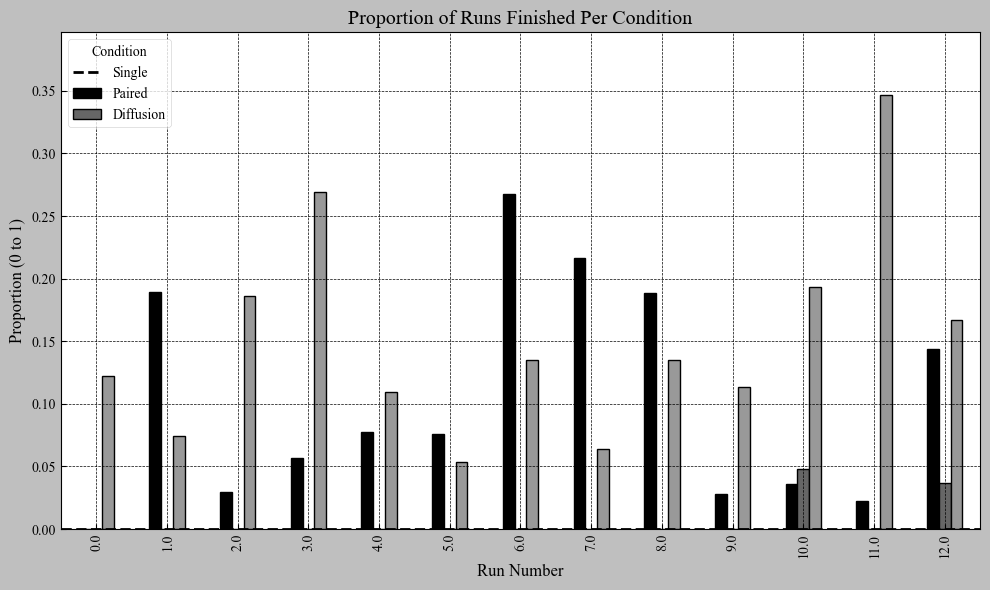

C:\Users\willb\AppData\Local\Temp\ipykernel_6804\3680289277.py:675: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Getting data into time format...


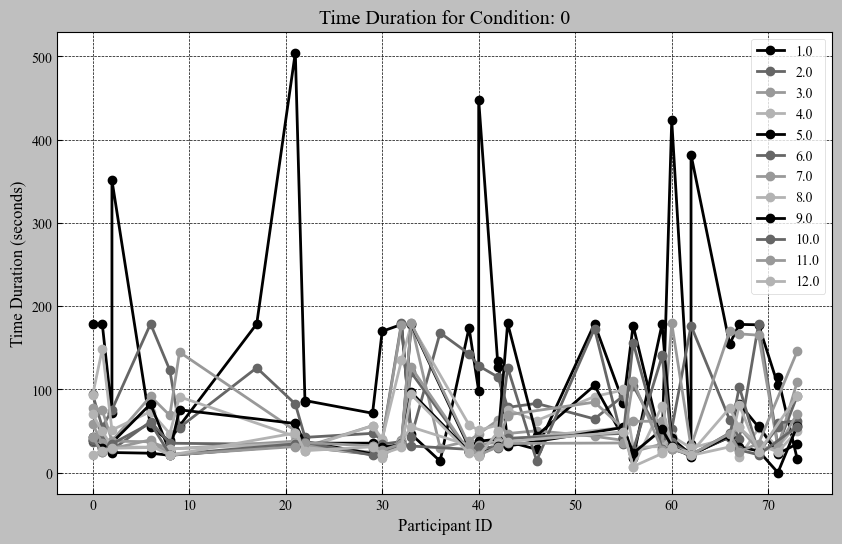

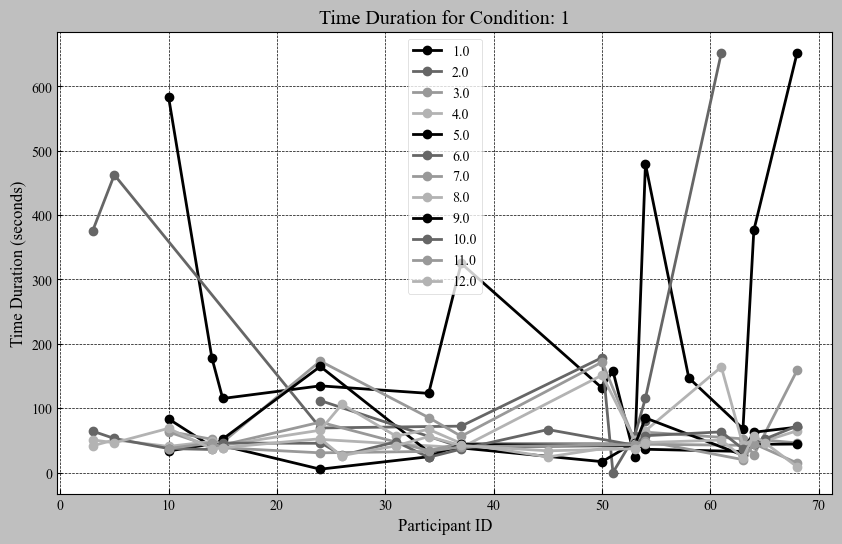

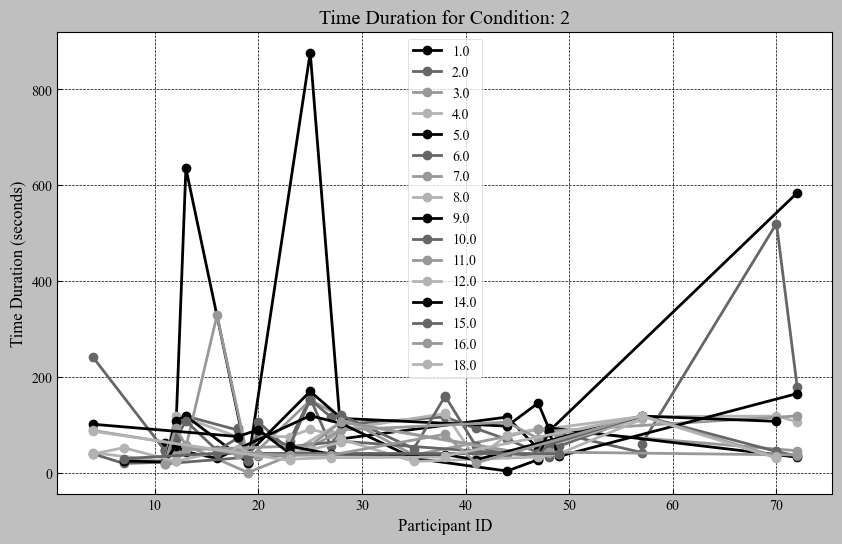

Getting data into time format...


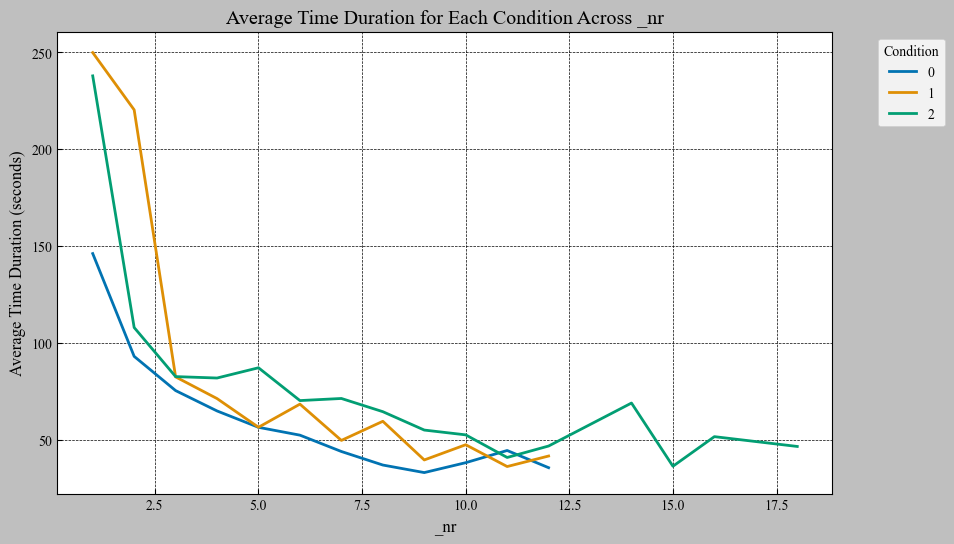

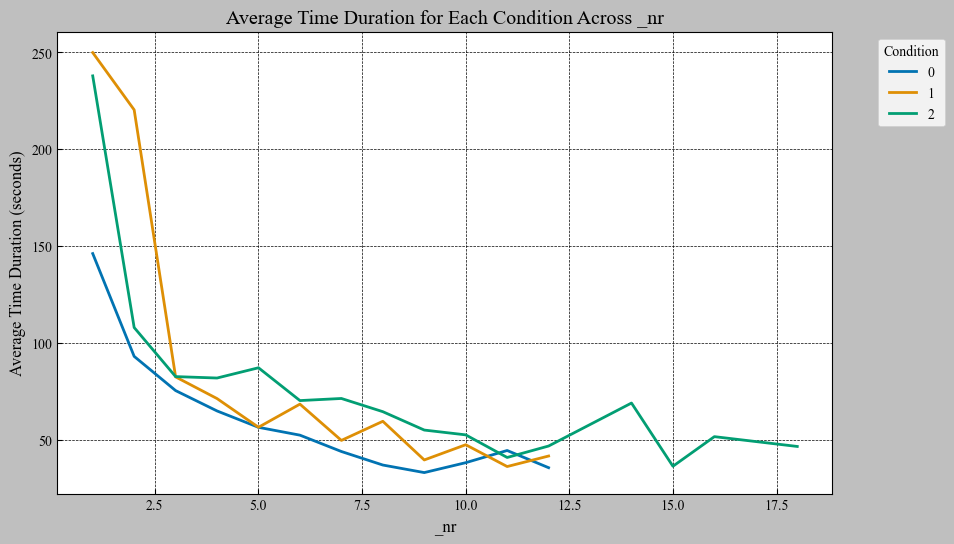

Descriptives
--------------------------------------------------
Calculating descriptive statistics...
       Unnamed: 0          ID  consent  age_years  is_human  condition_part_1  \
count   96.000000   96.000000     96.0  96.000000      96.0         96.000000   
mean    76.145833  303.895833      1.0  23.593750       1.0          0.822917   
std     55.153752  108.805329      0.0   7.719528       0.0          0.807788   
min      0.000000   67.000000      1.0  19.000000       1.0          0.000000   
25%     23.750000  268.750000      1.0  20.000000       1.0          0.000000   
50%     64.000000  330.500000      1.0  21.000000       1.0          1.000000   
75%    137.250000  401.250000      1.0  22.000000       1.0          1.250000   
max    165.000000  429.000000      1.0  55.000000       1.0          2.000000   

       condition_part_2  
count         96.000000  
mean           0.947917  
std            0.223361  
min            0.000000  
25%            1.000000  
50%         

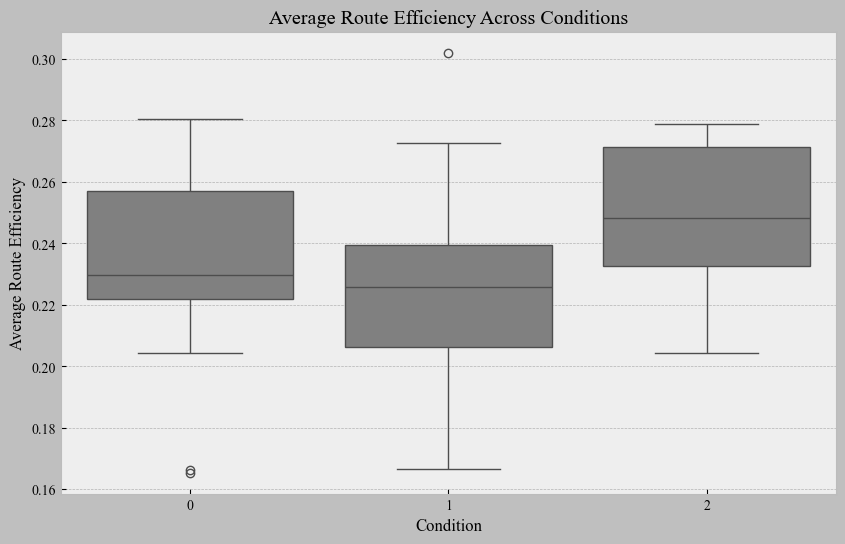



pre-reg with session_id as random effect
              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_route_efficiency
No. Observations: 68      Method:             REML                
No. Groups:       51      Scale:              0.0006              
Min. group size:  1       Log-Likelihood:     137.4291            
Max. group size:  3       Converged:          Yes                 
Mean group size:  1.3                                             
-------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept            0.232     0.005  44.313  0.000   0.221   0.242
condition_part_1     0.005     0.004   1.205  0.228  -0.003   0.014
Group Var            0.000     0.013                               



c:\Users\willb\.conda\envs\WeavingChange\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



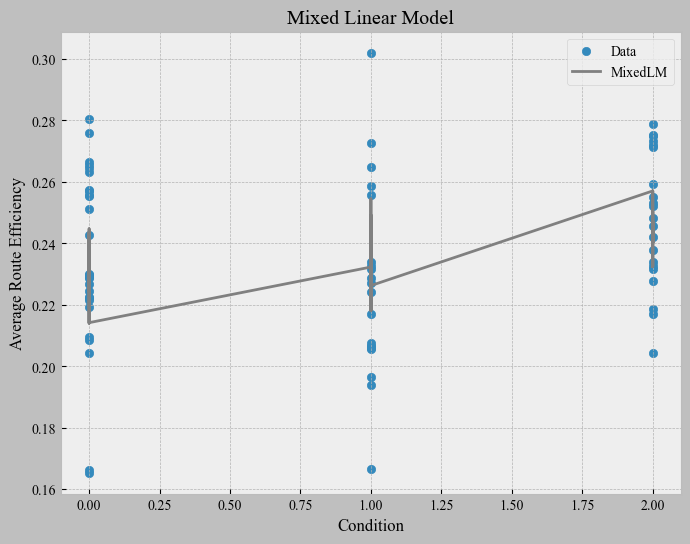

--------------------------------------------------


Planned Comparisons
--------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   -0.008 0.5957 -0.0278 0.0117  False
     0      2   0.0129 0.2579 -0.0066 0.0324  False
     1      2    0.021   0.05     0.0 0.0419   True
---------------------------------------------------
Cohen's d: 0.1896718948625988
Between-group variance: nan
Within-group variance: 0.000220473706627897


C:\Users\willb\AppData\Local\Temp\ipykernel_6804\3680289277.py:875: RuntimeWarning:

Mean of empty slice



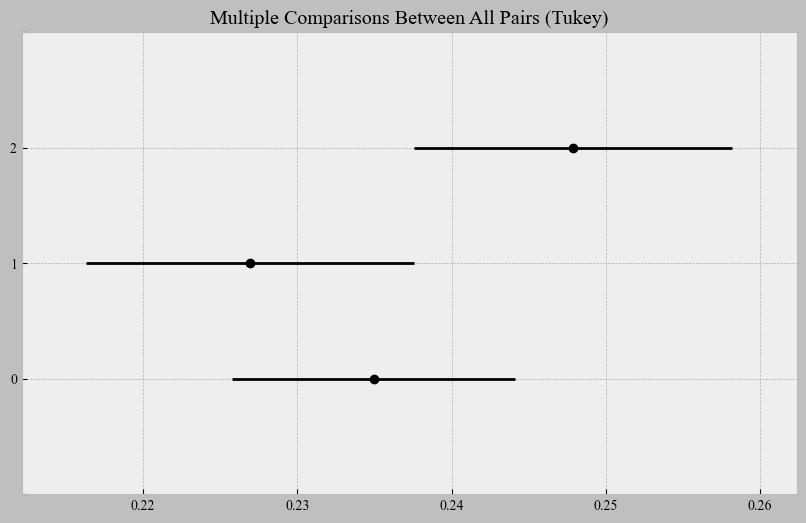

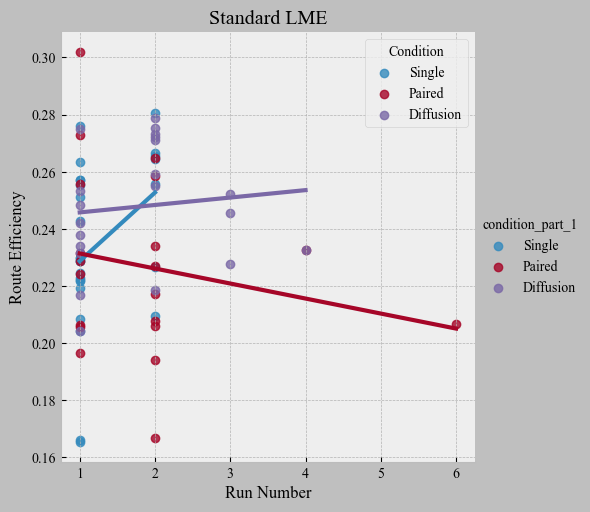



Run Number * Condition LME
              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_route_efficiency
No. Observations: 1050    Method:             REML                
No. Groups:       52      Scale:              0.0004              
Min. group size:  1       Log-Likelihood:     2578.1285           
Max. group size:  502     Converged:          Yes                 
Mean group size:  20.2                                            
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.236    0.004 58.280 0.000  0.228  0.244
condition_part_1        -0.002    0.002 -1.530 0.126 -0.005  0.001
_nr                      0.000    0.000  0.301 0.763 -0.000  0.001
condition_part_1:_nr     0.000    0.000  2.631 0.009  0.000  0.001
Group Var                0.001    0.008         

c:\Users\willb\.conda\envs\WeavingChange\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



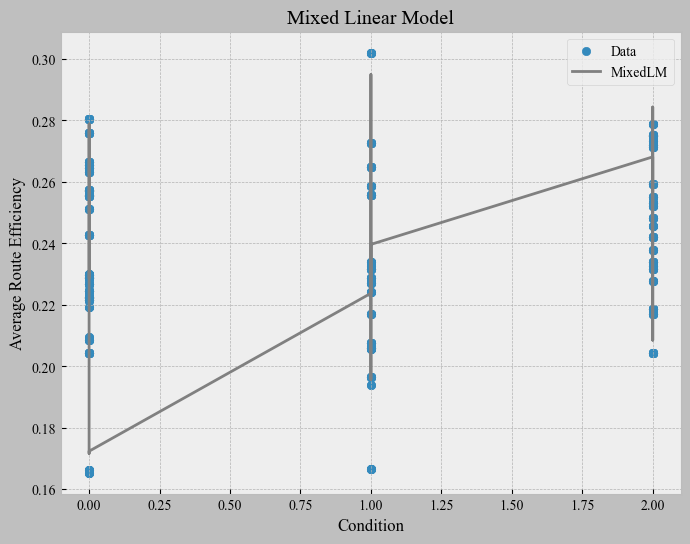

--------------------------------------------------


Planned Comparisons
--------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     0      1  -0.0086   0.0 -0.0132 -0.004   True
     0      2   0.0049 0.015  0.0008  0.009   True
     1      2   0.0135   0.0  0.0085 0.0184   True
--------------------------------------------------


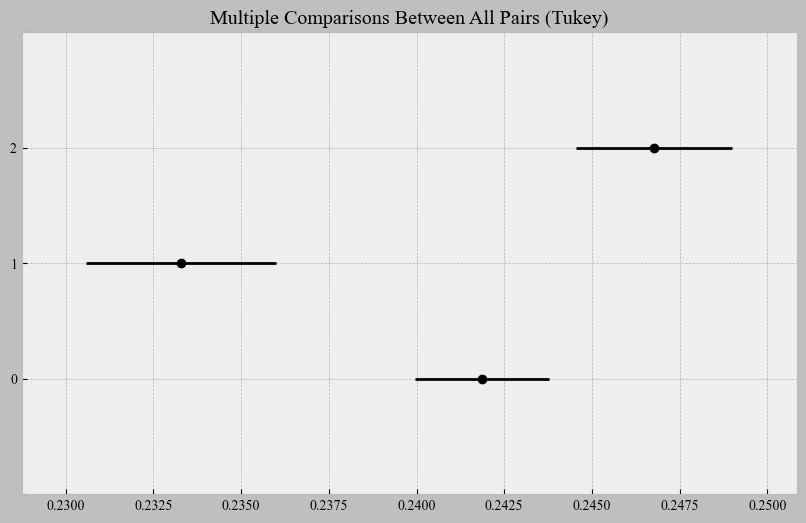

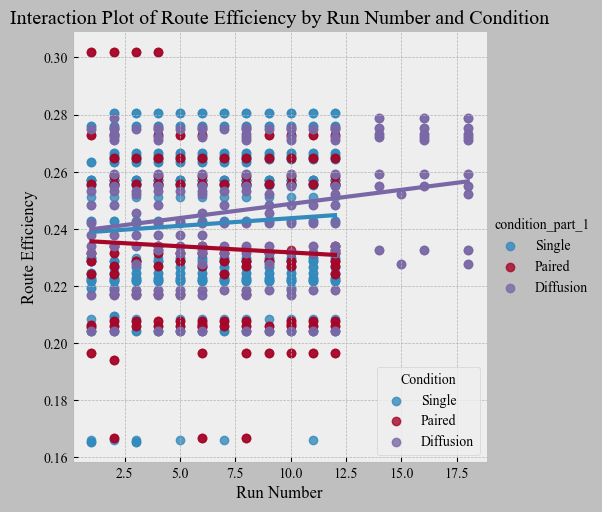

In [12]:
# create instance of data analysis class (raw file location, output folder)
data_analysis = DataAnalysisCCE('data/', 'output/')
data_analysis.remove_incomplete = True
data_analysis.wrangle(ready_made=True) # set ready_made to True if you have already wrangled the data
data_analysis.visualize()
data_analysis.analyze()

### Descriptives of route efficiency

In [107]:
# descriptives of route efficiency
df = pd.read_csv('output/route_efficiency_analysis.csv')
df = df.dropna(subset=['route_efficiency'])
df = data_analysis.kill_outliers(df, 'route_efficiency')
print(df['route_efficiency'].describe())

count    625.000000
mean       0.225668
std        0.050480
min        0.106607
25%        0.199280
50%        0.232751
75%        0.260418
max        0.372114
Name: route_efficiency, dtype: float64


### Route Efficiency and Paths of Single Participant

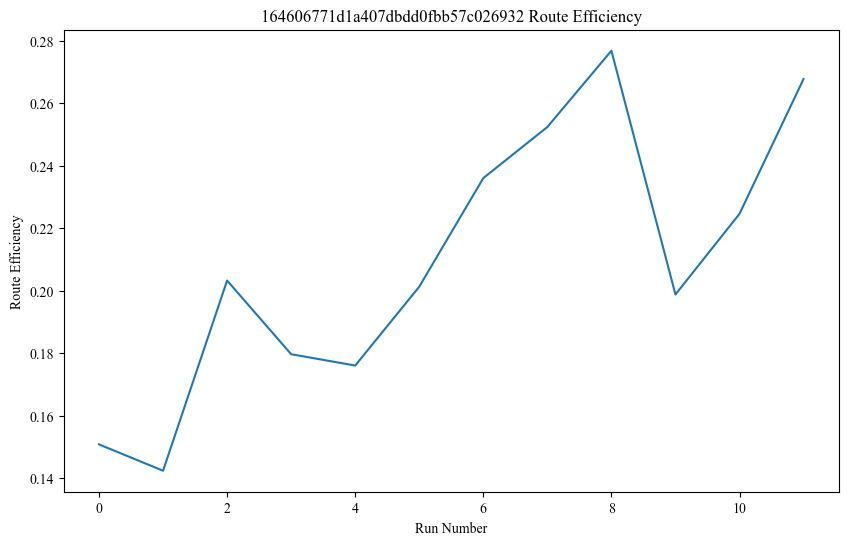

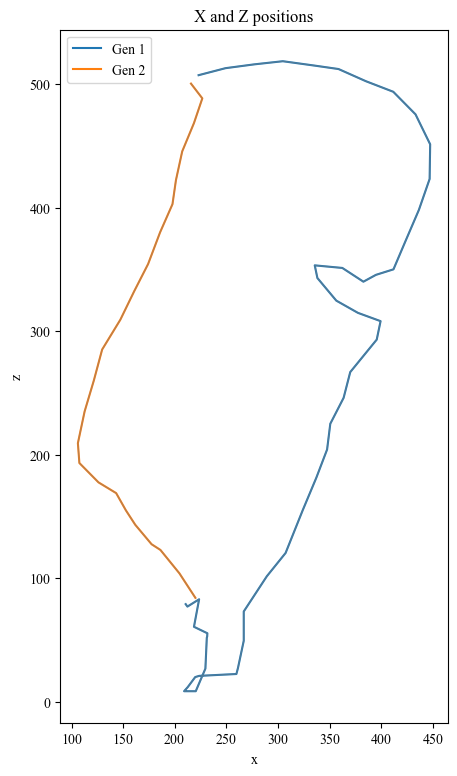

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def get_participant(id):
    df = data_analysis.data.copy()
    df.columns = df.columns.str.lower()
    annie = df[df['participant_id'] == id]
    annie['nr'] = pd.to_numeric(annie['nr'])
    annie['run_id'] = annie['run_id'].astype('str')
    annie = annie[annie['run_id'] != '0']
    annie_run = {'total_distance':[], 'nr':[], 'route_efficiency':[]}
    c = 0
    for r in annie['run_id'].unique():
        for i in range(1, 7):
            x = annie[(annie['nr'] == i) & (annie['run_id'] == r)] 
            y = data_analysis.get_cumulative_distance(x)
            annie_run['total_distance'].append(data_analysis.get_cumulative_distance(x)[0])
            annie_run['route_efficiency'].append(data_analysis.get_cumulative_distance(x)[1])
            annie_run['nr'].append(c)
            c+=1

    an = pd.DataFrame(annie_run)
    an.to_csv('data/annie.csv')

    # Plot route efficiency
    plt.figure(figsize=(10, 6))
    plt.plot(an['nr'], an['route_efficiency'])
    plt.title(f'{id} Route Efficiency')
    plt.xlabel('Run Number')
    plt.ylabel('Route Efficiency')
    plt.show()

    lower_threshold = np.percentile(annie['x'], 1)
    upper_threshold = np.percentile(annie['x'], 99)

    # Filter the dataframe to remove outliers
    filtered_annie = annie[(annie['x'] > lower_threshold) & (annie['x'] < upper_threshold)]
    filtered_annie = filtered_annie[filtered_annie['z'] > 0]
    # Sort the DataFrame by 'x' to ensure the line connects the points in order
    filtered_annie = filtered_annie.sort_values(by='t')

    plt.rcParams['font.family'] = 'Times New Roman'

    # Plot x and z positions with color defined by _nr and connect sequential points with lines
    plt.figure(figsize=(5, 9))  # Adjust figure size here
    xc = 1
    for nr, group in filtered_annie.groupby('run_id'):
        group = group.sort_values(by='t')
        group = group[(group['_nr'] == 6) | (group['_nr'] == 12)]
        plt.plot(group['x'], group['z'], label=f'Gen {xc}')
        plt.plot(group['x'], group['z'], linestyle='-', linewidth=1, color='gray', alpha=0.5)  # Connect sequential points
        xc += 1

    plt.title('X and Z positions')
    plt.xlabel('x')
    plt.ylabel('z')
    plt.legend()
    plt.show()


get_participant('164606771d1a407dbdd0fbb57c026932')
